Get Data

In [1]:
import opendatasets as od 
import pandas as pd
import numpy as np
import os

if not os.path.exists('steam-games-dataset'):
    od.download( 
        "https://www.kaggle.com/datasets/fronkongames/steam-games-dataset/data") 
    
if not os.path.exists('steam-video-games'):
    od.download( 
        "https://www.kaggle.com/datasets/tamber/steam-video-games/data") 
    
if not os.path.exists('popularity-of-games-on-steam'):
    od.download( 
        "https://www.kaggle.com/datasets/michau96/popularity-of-games-on-steam") 

Load Data

In [2]:
user_data = pd.read_csv('steam-video-games\steam-200k.csv', encoding='ISO-8859-1', usecols=[0, 1, 2, 3], names=['UserID', 'Game', 'Behavior', 'Quantity'])
# Note: Behvior is either purchase or play. When behavior is purchase, quantity is always 1. When behavior is play, quantity is the number of hours
user_data.head(10)

,UserID,Game,Behavior,Quantity
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
5,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,purchase,1.0
7,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,purchase,1.0
9,151603712,Left 4 Dead 2,play,8.9


Find average hours played per game

In [3]:
hours_played = user_data[user_data['Behavior'] == 'play'].groupby('Game').agg(np.mean).sort_values(by='Quantity', ascending=False).drop('UserID', axis='columns')
hours_played.head(20)

,Quantity
Game,
Eastside Hockey Manager,1295.000000
Baldur's Gate II Enhanced Edition,475.255556
FIFA Manager 09,411.000000
Perpetuum,400.975000
Football Manager 2014,391.984615
Football Manager 2012,390.453165
Football Manager 2010,375.048571
Football Manager 2011,365.703226
Freaking Meatbags,331.000000


Normalize play quantity

In [4]:
normalized_user_data = user_data.copy()[user_data['Game'].isin(hours_played.index)]
normalized_user_data['Quantity'] = normalized_user_data.apply(lambda x: x['Quantity'] if x['Behavior'] == 'purchase' else x['Quantity'] / hours_played.loc[x['Game'], :]['Quantity'], axis=1)
normalized_user_data.head(10)

,UserID,Game,Behavior,Quantity
0,151603712,The Elder Scrolls V Skyrim,purchase,1.000000
1,151603712,The Elder Scrolls V Skyrim,play,2.607178
2,151603712,Fallout 4,purchase,1.000000
3,151603712,Fallout 4,play,1.349928
4,151603712,Spore,purchase,1.000000
5,151603712,Spore,play,0.506387
6,151603712,Fallout New Vegas,purchase,1.000000
7,151603712,Fallout New Vegas,play,0.234121
8,151603712,Left 4 Dead 2,purchase,1.000000
9,151603712,Left 4 Dead 2,play,0.212190


Combine rows

In [5]:
grouped_users = normalized_user_data.groupby(['UserID', 'Game']).aggregate({'Quantity': 'sum'})
grouped_users = grouped_users.reset_index(level='Game')
grouped_users.loc[151603712]

,Game,Quantity
UserID,,
151603712,Alan Wake,1.000000
151603712,BioShock,1.065645
151603712,BioShock 2,1.000000
151603712,BioShock Infinite,1.074707
151603712,Dead Island Epidemic,1.239623
151603712,Dota 2,1.002466
151603712,Dragon Age Origins - Ultimate Edition,1.030049
151603712,Eldevin,1.021525
151603712,Fallen Earth,1.000000


Pivot long to wide

In [6]:
pivoted_users = grouped_users.reset_index()
pivoted_users = pivoted_users.set_index(['UserID', 'Game'])
pivoted_users = pivoted_users.unstack(fill_value=0)
pivoted_users.head()

Quantity            \
Game   007 Legends 0RBITALIS   
UserID                         
5250           0.0       0.0   
76767          0.0       0.0   
86540          0.0       0.0   
103360         0.0       0.0   
144736         0.0       0.0   

                                                                   \
Game   1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   
UserID                                                              
5250                                                  0.0           
76767                                                 0.0           
86540                                                 0.0           
103360                                                0.0           
144736                                                0.0           

                                                               \
Game   10 Second Ninja 10,000,000 100% Orange Juice 1000 Amps   
UserID                                                          
5250               0.0        0.0               0.0       0.0   
76767              0.0        0.0               0.0       0.0   
86540              0.0        0.0               0.0       0.0   
103360             0.0        0.0               0.0       0.0   
144736             0.0        0.0               0.0       0.0   

                                                                         \
Game   12 Labours of Hercules 12 Labours of Hercules II The Cretan Bull   
UserID                                                                    
5250                      0.0                                       0.0   
76767                     0.0                                       0.0   
86540                     0.0                                       0.0   
103360                    0.0                                       0.0   
144736                    0.0                                       0.0   

                                              ...                             \
Game   12 Labours of Hercules III Girl Power  ... rFactor rFactor 2 realMyst   
UserID                                        ...                              
5250                                     0.0  ...     0.0       0.0      0.0   
76767                                    0.0  ...     0.0       0.0      0.0   
86540                                    0.0  ...     0.0       0.0      0.0   
103360                                   0.0  ...     0.0       0.0      0.0   
144736                                   0.0  ...     0.0       0.0      0.0   

                                                                              \
Game   realMyst Masterpiece Edition resident evil 4 / biohazard 4 rymdkapsel   
UserID                                                                         
5250                            0.0                           0.0        0.0   
76767                           0.0                           0.0        0.0   
86540                           0.0                           0.0        0.0   
103360                          0.0                           0.0        0.0   
144736                          0.0                           0.0        0.0   

                                                                          
Game   sZone-Online the static speaks my name theHunter theHunter Primal  
UserID                                                                    
5250            0.0                       0.0       0.0              0.0  
76767           0.0                       0.0       0.0              0.0  
86540           0.0                       0.0       0.0              0.0  
103360          0.0                       0.0       0.0              0.0  
144736          0.0                       0.0       0.0              0.0  

[5 rows x 3600 columns]

Train test split

In [7]:
data = pivoted_users.sample(frac=1)
split_index = int(data.shape[0] * 0.8)
train = data[:split_index]
test = data[split_index:]

PCA

In [8]:
from sklearn.decomposition import PCA

# Cross val
var_ratio = []
for n in range(20, 301, 20):    
    pca_test = PCA(n_components=n).fit(train.values) #.values supresses warning about feature names
    var_ratio.append(np.sum(pca_test.explained_variance_ratio_))

Plot Variances

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Explained Variance')

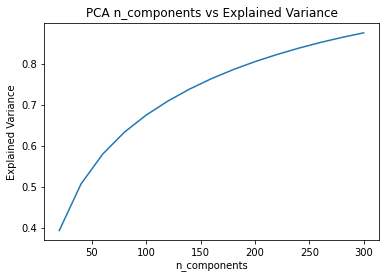

In [10]:
plt.plot(range(20, 301, 20), var_ratio)
plt.title("PCA n_components vs Explained Variance")
plt.xlabel("n_components")
plt.ylabel("Explained Variance")

In [11]:
pca = PCA(n_components=200)
train_pca = pca.fit_transform(train.values)

test_pca = pca.transform(test.values)

np.sum(pca.explained_variance_ratio_)

0.8051950781509263

Nearest Neighbors

In [12]:
from sklearn.neighbors import KDTree
tree = KDTree(train_pca) 

In [13]:
biggest_test_user = test.sum(axis=1).idxmax()
biggest_test_user_index = test.index.get_loc(biggest_test_user)

biggest_test_user

11403772

In [14]:
test.loc[biggest_test_user].sort_values(ascending=False)[:10]

          Game                                            
Quantity  Dota 2                                              13.047213
          Team Fortress 2                                     10.951512
          Might & Magic Duel of Champions                      7.277641
          HAWKEN                                               6.747370
          Insurgency Modern Infantry Combat                    6.723700
          Nosgoth                                              6.307745
          Ravaged Zombie Apocalypse                            4.394737
          Unreal Tournament 3 Black Edition                    4.140346
          EVE Online                                           4.124488
          Magic The Gathering - Duels of the Planeswalkers     3.957746
Name: 11403772, dtype: float64

In [15]:
neighbors = tree.query(test_pca[biggest_test_user_index:biggest_test_user_index+1], k=10, return_distance=False)[0]
neighbors

array([ 655, 9651,  874, 6702, 7153, 8787, 6586, 1269,  574,  780],
      dtype=int64)

In [16]:
for neighbor in neighbors:
    print(train.iloc[neighbor].sort_values(ascending=False)[:10])

          Game                
Quantity  Team Fortress 2         6.912054
          Dota 2                  5.137377
          Evil Genius             3.977667
          Terraria                3.395849
          Just Cause 2            2.721475
          Just Cause              1.828829
          Osmos                   1.810526
          Kerbal Space Program    1.809823
          Torchlight              1.777133
          PC Gamer                1.666667
Name: 11794760, dtype: float64
          Game                           
Quantity  Dota 2                             14.585784
          Counter-Strike Global Offensive     5.334433
          Path of Exile                       3.569019
          Gumboy Crazy Features               3.250000
          Super Hexagon                       2.439282
          Lume                                2.333333
          BIT.TRIP RUNNER                     2.195652
          Windosill                           1.610169
          Defy Gravity    

Sum neighbors values

In [17]:
combined_neighbors = train.iloc[neighbors].sum().T.sort_values(ascending=False).reset_index().set_index('Game').drop('level_0', axis='columns').rename(columns={0: 'Quantity'})
combined_neighbors.head(10)

,Quantity
Game,
Dota 2,111.049632
Team Fortress 2,32.891154
Counter-Strike Global Offensive,20.072003
Left 4 Dead 2,14.282269
Terraria,10.197537
Counter-Strike Condition Zero,10.062264
The Elder Scrolls V Skyrim,9.147609
Counter-Strike Source,8.353181
Magicka,8.268624


In [18]:
# Get games owned by user
user_games = test.loc[biggest_test_user].reset_index().set_index('Game').drop('level_0', axis='columns').rename(columns={biggest_test_user: 'Quantity'})
user_games = list(user_games[user_games['Quantity'] == 0.0].index)

recommendations = []
i = 0
while len(recommendations) < 10:
    game_name = combined_neighbors.iloc[i].name
    if game_name in user_games:
        recommendations.append(game_name)
    i += 1

recommendations

['Counter-Strike Condition Zero',
 'BIT.TRIP RUNNER',
 'The Witcher 2 Assassins of Kings Enhanced Edition',
 'Grand Theft Auto IV',
 'Fallout 4',
 'The Witcher 3 Wild Hunt',
 'Day of Defeat Source',
 'Clicker Heroes',
 'Defy Gravity',
 'Just Cause 2']

No train/test split

In [19]:
pca_data = pca.fit_transform(pivoted_users.values)

N_NEIGHBORS = 100
user_index = pivoted_users.index.get_loc(biggest_test_user)
neighbors = tree.query(pca_data[user_index:user_index+1], k=N_NEIGHBORS, return_distance=False)[0]
combined_neighbors = pivoted_users.iloc[neighbors].sum().T.sort_values(ascending=False).reset_index().set_index('Game').drop('level_0', axis='columns').rename(columns={0: 'Quantity'})

# Get Recommendations
user_games = pivoted_users.loc[biggest_test_user].reset_index().set_index('Game').drop('level_0', axis='columns').rename(columns={biggest_test_user: 'Quantity'})
user_games = list(user_games[user_games['Quantity'] != 0.0].index)

recommendations = []
i = 0
while len(recommendations) < 10:
    game_name = combined_neighbors.iloc[i].name
    if game_name not in user_games:
        recommendations.append(game_name)
    i += 1

recommendations

["Don't Starve",
 'War Thunder',
 'Just Cause 2',
 '7 Days to Die',
 'Echo of Soul',
 'Heroes & Generals',
 'Sleeping Dogs',
 'Neverwinter',
 'Day of Defeat Source',
 'Grand Theft Auto V']

In [20]:
combined_neighbors.head(25)

,Quantity
Game,
Dota 2,52.103015
Half-Life 2 Deathmatch,48.230763
Don't Starve,31.118540
Team Fortress 2,25.862564
Half-Life 2,23.325306
Counter-Strike Global Offensive,22.470446
War Thunder,22.012127
Portal,21.156475
Half-Life 2 Lost Coast,20.279284


Testing getting the amount of data on the user

In [26]:
pivoted_users.shape[1] - pivoted_users.loc[biggest_test_user].isin([0.0]).sum()

525